In [1]:
# Import packages

import os, scanpy as sc

# Path to raw data file

SL040_PATH = "SL040_raw.h5ad"  
assert os.path.exists(SL040_PATH), "SL040_raw.h5ad not found"

# Load raw SL040 data

ad_sl040_raw = sc.read_h5ad(SL040_PATH)
ad_sl040_raw.var_names_make_unique()

print("✅ Loaded SL040_raw.h5ad")
print("Shape:", ad_sl040_raw.shape)
print("obs columns:", list(ad_sl040_raw.obs.columns)[:15])


✅ Loaded SL040_raw.h5ad
Shape: (135482, 58234)
obs columns: ['Fluorescence', 'Location', 'MitoFraction', 'NeftelClass', 'UnsplicedFraction', 'Zone', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'total_genes']


In [2]:
# QC plotting function

def qc_plots(adata, tag):
    # Violin plots for QC metrics 
    
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
        save=f"_{tag}_qc_violin.png"
    )
    # Scatter: total counts vs MT percentage
    
    sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt",
                  save=f"_{tag}_qc_scatter_counts_vs_mt.png")
    # Scatter: total counts vs number of genes detected
    
    sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts",
                  save=f"_{tag}_qc_scatter_counts_vs_genes.png")

# Main processing pipeline

def standard_pipeline_dual_single(ad_sl040_raw, tag="SL040_clean",
                                  mito_thresh=15, n_hvg=4000, n_pcs=50, res=0.8):

    # Flag mitochondrial genes 
    
    ad_sl040_raw.var['mt'] = ad_sl040_raw.var['feature_name'].str.upper().str.startswith('MT-')

    # Calculate QC metrics & plot before filtering
    
    sc.pp.calculate_qc_metrics(ad_sl040_raw, qc_vars=['mt'], inplace=True)
    qc_plots(ad_sl040_raw, tag=f"{tag}_BEFORE")

    # Filter low-quality cells
    
    filt = (ad_sl040_raw.obs["n_genes_by_counts"] >= 200) & \
           (ad_sl040_raw.obs["pct_counts_mt"] < mito_thresh)
    ad_sl040_qc = ad_sl040_raw[filt].copy()
    qc_plots(ad_sl040_qc, tag=f"{tag}_AFTER")

    # Save the QC-only version (for CNV)
    
    ad_sl040_qc.write(f"{tag}_QC_only_for_CNV.h5ad")

    # Normalize & log-transform for clustering
    
    sc.pp.normalize_total(ad_sl040_qc, target_sum=1e4)
    sc.pp.log1p(ad_sl040_qc)
    sc.pp.highly_variable_genes(ad_sl040_qc, flavor="seurat_v3",
                                n_top_genes=n_hvg, subset=True)

    # Scale, PCA, neighbors, UMAP, Leiden clustering
    
    sc.pp.scale(ad_sl040_qc, max_value=10)
    sc.tl.pca(ad_sl040_qc, n_comps=n_pcs)
    sc.pp.neighbors(ad_sl040_qc, n_neighbors=30, n_pcs=n_pcs)
    sc.tl.umap(ad_sl040_qc)
    sc.tl.leiden(ad_sl040_qc, resolution=res)

    # Plot final UMAP overlays
    
    sc.pl.umap(ad_sl040_qc,
               color=["n_genes_by_counts", "pct_counts_mt", "leiden"],
               save=f"_{tag}_UMAP_qc.png")

    # Save normalized dataset
    
    ad_sl040_qc.write(f"{tag}_QC_norm_integrated.h5ad")

    print(f"Finished {tag}")
    print("QC-only (raw) shape:", ad_sl040_raw.shape)
    print("Filtered + normalized shape:", ad_sl040_qc.shape)

    return ad_sl040_raw, ad_sl040_qc


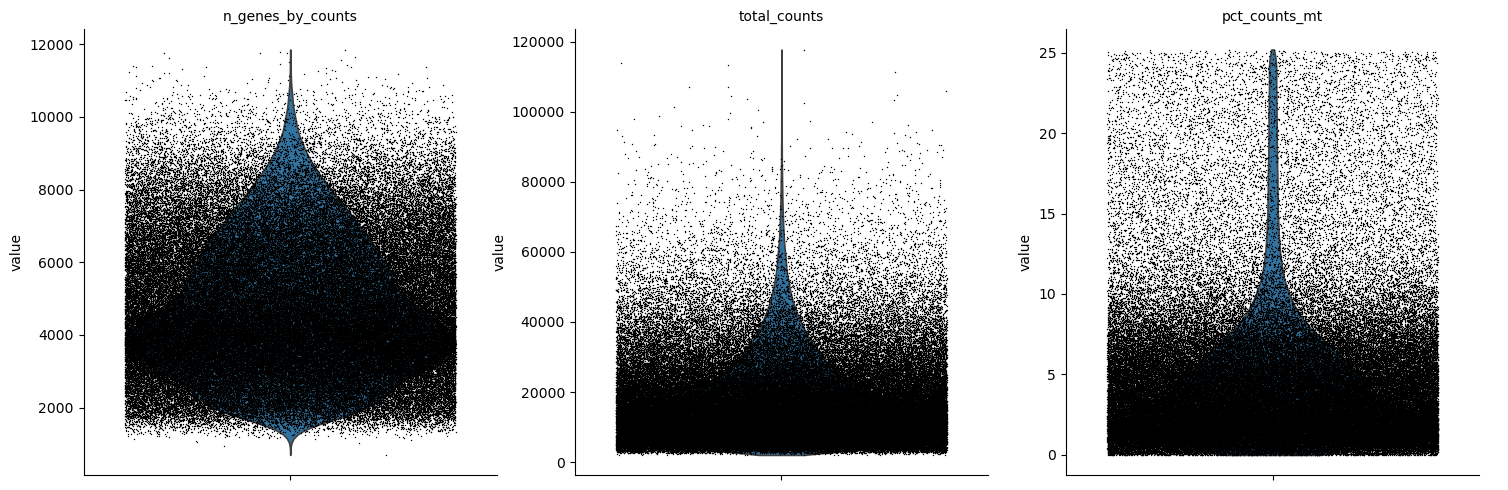

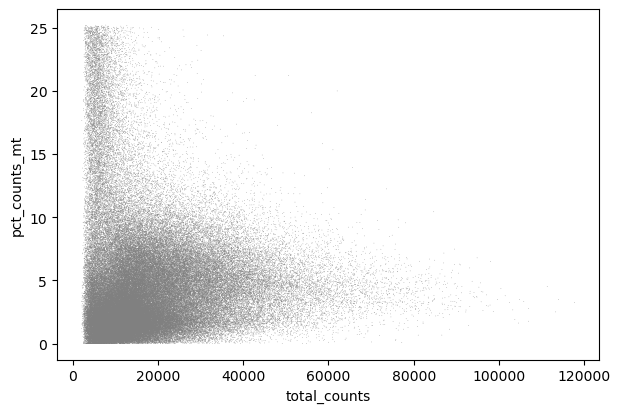

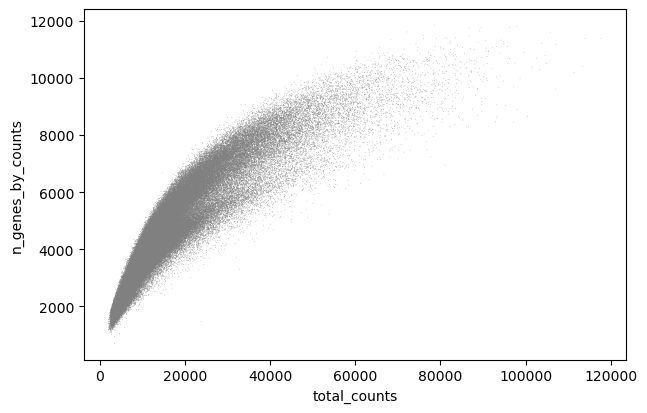

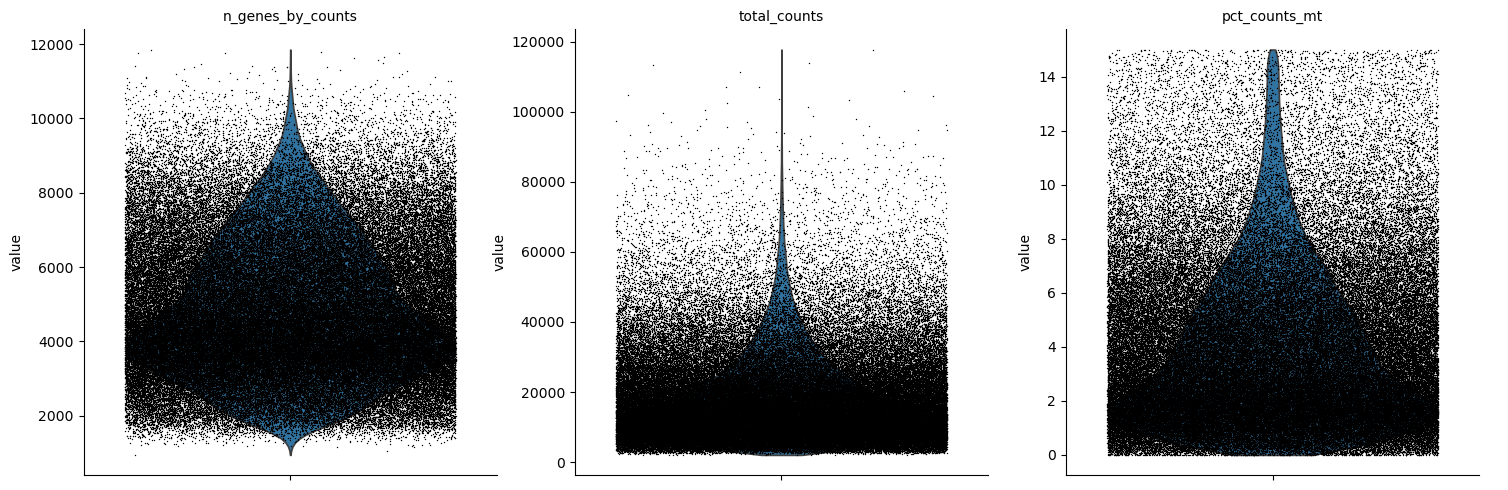

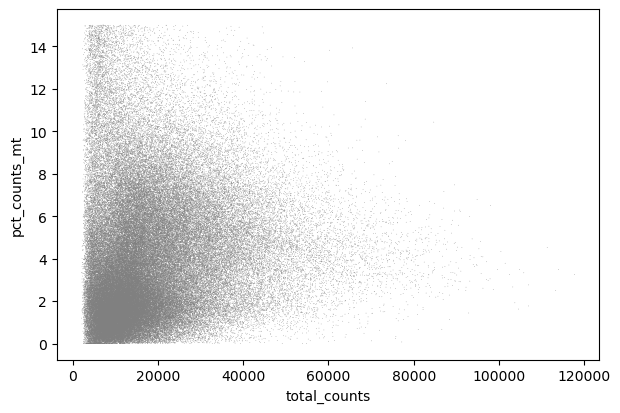

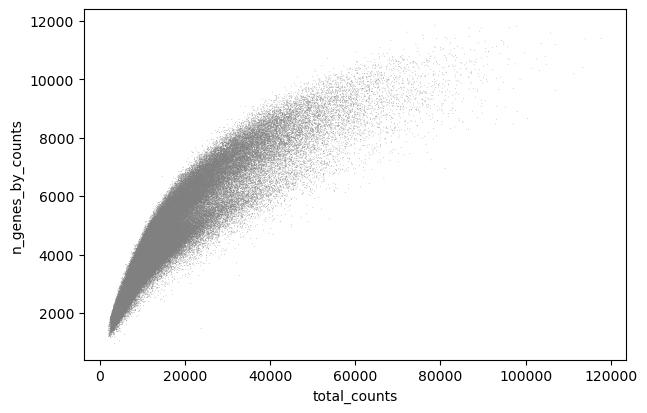

/Users/baileyorange/micromamba/envs/gbm_mtor/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/Users/baileyorange/micromamba/envs/gbm_mtor/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/var/folders/t7/vzbzd0xj40jbwddqp7614wm80000gn/T/ipykernel_24564/1625921681.py:60: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ad_sl040_qc, resolution=res)


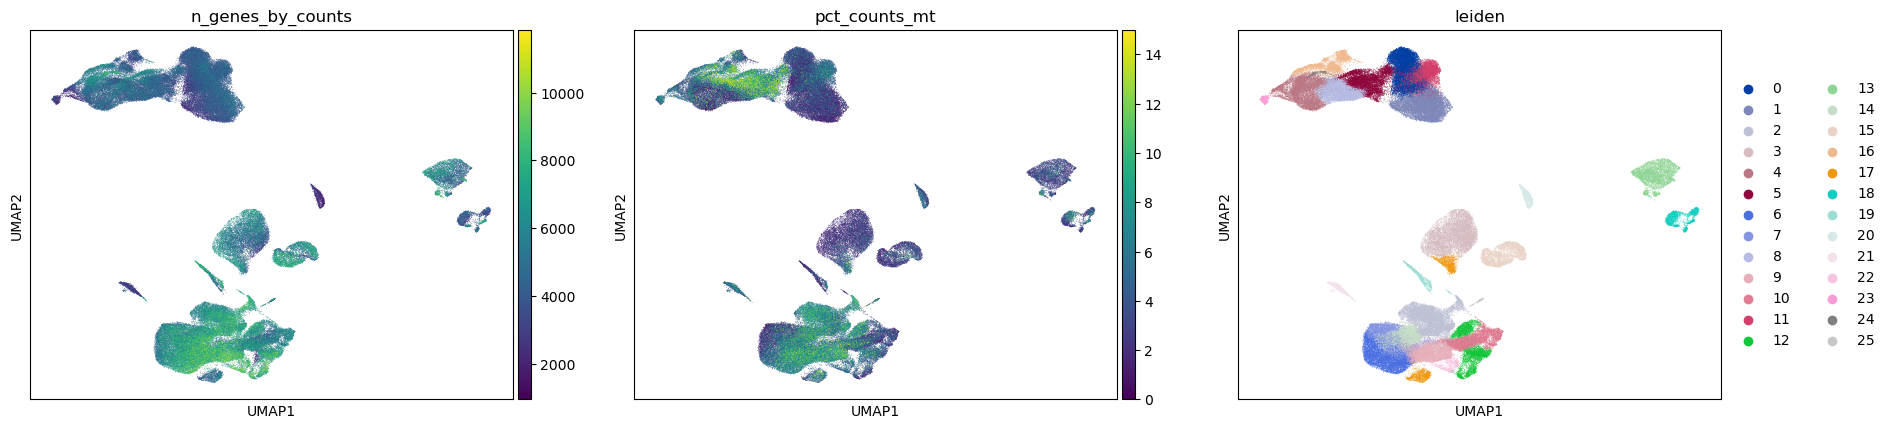

Finished SL040_clean
QC-only (raw) shape: (135482, 58234)
Filtered + normalized shape: (129491, 4000)


In [3]:
# Run the full SL040 preprocessing pipeline:
#   - ad_sl040_qc_raw  = QC-only version (used for CNV)
#   - ad_sl040_qc_norm = QC + normalized + clustered version (used for UMAP/clustering)

ad_sl040_qc_raw, ad_sl040_qc_norm = standard_pipeline_dual_single(
    ad_sl040_raw,          
    tag="SL040_clean"      
)

